**Akut lenfoblastik lösemi (ALL), çocukluk çağı kanserlerinin en sık görülen türüdür ve çocukluk çağı kanserlerinin yaklaşık %25'ini oluşturur.**

Bu hücreler mikroskobik görüntülerden segmentlere ayrılmış olup gerçek dünyadaki görüntüleri temsil etmektedirler çünkü bazı boyama gürültüsü ve aydınlatma hataları içermektedirler, ancak bu hatalar büyük ölçüde edinim süreci sırasında düzeltilmiştir.

Normal hücrelerden mikroskop altında olgunlaşmamış lösemik blastları tanımlama görevi, morfolojik benzerlik nedeniyle zordur ve bu nedenle temel gerçek etiketler bir uzman onkolog tarafından açıklanmıştır.

Toplamda 118 hastaya ait 15.135 görüntü var ve iki etiketli sınıf var:
*   Normal hücre
*   Lösemi patlaması

# Teşekkürler
Gupta, A. ve Gupta, R. (2019). ISBI 2019 ALL Challenge veri seti [Veri seti]. Kanser Görüntüleme Arşivi. https://doi.org/10.7937/tcia.2019.dc64i46r

> Bu veri setini seçmemdeki sebep sevdiğim insanların bu hastalıktan muzdarip olmasıdır.



# Veri Seti
andrewmvd -
Leukemia Classification
# Kaggle Linki
https://www.kaggle.com/datasets/andrewmvd/leukemia-classification/data
# Çalışma Konusu
Normal hücre görüntülerini anormal hücre görüntülerinden ayıran bir model oluşturarak önemli çocukluk çağı kanser türlerinden birini ele alınıştır.
# Veri Seti Amacı
Lösemik B-lenfoblast hücrelerinin (kanser hücreleri) normal B-lenfoidlerden ayırarak sınıflandırılması

**Veri Setinin tam anlamıyla yapısı, amacı, sahipliği, açıklaması için ek https://wiki.cancerimagingarchive.net/download/attachments/52758223/CNMC_readme.pdf?api=v2**

In [2]:
# Burada Kaggle dan veri setini çekmek için kaggle kuruyoruz.
!pip install kaggle

In [8]:
# kaggle.json ı yerelden yüklemek
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ugurrucr","key":"ba2f6f21b6cac37bd939d020ce9cd357"}'}

In [9]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [11]:
!chmod 600 /root/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d andrewmvd/leukemia-classification

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/leukemia-classification
License(s): other
100% 866M/867M [00:03<00:00, 291MB/s]
100% 867M/867M [00:03<00:00, 262MB/s]


In [18]:
!unzip /content/leukemia-classification.zip -d /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_5_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_7_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_1_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_2_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_3_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_1_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_2_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_3_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_4_all.bmp  
  inflating: /content/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_5_all.bmp  
  inflating: /content/C-NMC_L

In [22]:
!ls /content/C-NMC_Leukemia/

testing_data  training_data  validation_data


In [50]:
# Gerekli kütüphaneleri yükleme
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [52]:
# Validation verisi ve etiketlerini yüklemek
def load_validation_images(validation_folder, labels_file):
    images = []
    labels = []

    # Etiketlerin bulunduğu CSV dosyasını yükle
    labels_df = pd.read_csv(labels_file)

    # CSV dosyasındaki etiketleri kontrol etme
    print("Etiketler:", labels_df.head())

    # Validation verisi dizininde gezinme
    for file_name in os.listdir(validation_folder):
        image_path = os.path.join(validation_folder, file_name)

        # Görseli yükleyin
        img = image.load_img(image_path, target_size=(64, 64))
        img_array = image.img_to_array(img)
        images.append(img_array)

        # Etiketleri CSV dosyasından alın
        # Burada 'new_names' ile eşleşme sağlıyoruz
        label_name = labels_df.loc[labels_df['new_names'] == file_name, 'labels'].values
        if len(label_name) > 0:
            # Etiketlerin '1' veya '0' gibi sayısal değerler olduğunu varsayıyoruz, 'ALL' veya 'Normal' olarak değiştirebiliriz
            labels.append('ALL' if label_name[0] == 1 else 'Normal')
        else:
            labels.append('Unknown')  # Etiket bulunamazsa 'Unknown' ekle

    return np.array(images), np.array(labels)

In [53]:
# Eğitim verisini yükleme
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for fold in os.listdir(folder):
        fold_path = os.path.join(folder, fold)
        if os.path.isdir(fold_path) and fold.startswith('fold'):
            for folder_name in os.listdir(fold_path):
                folder_path = os.path.join(fold_path, folder_name)
                if os.path.isdir(folder_path):
                    # Etiket belirleme (all -> 'ALL', hem -> 'Normal')
                    if folder_name == 'all':
                        label_name = 'ALL'  # Kanserli hücreler
                    elif folder_name == 'hem':
                        label_name = 'Normal'  # Sağlıklı hücreler
                    else:
                        continue  # Tanımlanamayan klasörleri atla
                    # Klasördeki tüm dosyalar üzerinde işlem yapma
                    for file_name in os.listdir(folder_path):
                        image_path = os.path.join(folder_path, file_name)

                        img = image.load_img(image_path, target_size=(64, 64))
                        img_array = image.img_to_array(img)
                        images.append(img_array)
                        labels.append(label_name)
    images = np.array(images)
    print(f"Yüklenen Görsellerin Şekli: {images.shape}")  # Görsellerin boyutunu kontrol etme
    return images, np.array(labels)

In [54]:
# Eğitim ve validation verilerini yükleyin
train_dir = '/content/C-NMC_Leukemia/training_data'  # Buradaki yol, verinizin bulunduğu yol olmalı
train_images, train_labels = load_images_from_folder(train_dir, label='train')

validation_dir = '/content/C-NMC_Leukemia/validation_data'
validation_images, validation_labels = load_validation_images(
    '/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/',
    '/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv'
)

Yüklenen Görsellerin Şekli: (10661, 64, 64, 3)
Etiketler:              Patient_ID new_names  labels
0   UID_57_29_1_all.bmp     1.bmp       1
1   UID_57_22_2_all.bmp     2.bmp       1
2   UID_57_31_3_all.bmp     3.bmp       1
3  UID_H49_35_1_hem.bmp     4.bmp       0
4   UID_58_6_13_all.bmp     5.bmp       1


In [55]:
# Görselleri normalize etme
train_images = train_images / 255.0
validation_images = validation_images / 255.0

# Etiketleri sayısal değerlere dönüştürme (ALL -> 0, Normal -> 1)
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)

In [56]:
# CNN Modeli oluşturma
model = models.Sequential([
    layers.InputLayer(input_shape=(64, 64, 3)),  # Burada giriş şekli belirtilmeli
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  # Çıktı: 2 sınıf (ALL, Normal)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [57]:
# Modeli derleme
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Modeli eğitme (Validation verisi ile birlikte)
history = model.fit(train_images, train_labels_encoded, epochs=10,
                    validation_data=(validation_images, validation_labels_encoded))

# Modeli kaydetme
model.save('cancer_detection_model.keras')

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7760 - loss: 0.4921 - val_accuracy: 0.6856 - val_loss: 0.6815
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7965 - loss: 0.4627 - val_accuracy: 0.6909 - val_loss: 0.7279
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8078 - loss: 0.4343 - val_accuracy: 0.6786 - val_loss: 0.8141
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8219 - loss: 0.4140 - val_accuracy: 0.6958 - val_loss: 0.6456
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8409 - loss: 0.3803 - val_accuracy: 0.7076 - val_loss: 0.7831
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8424 - loss: 0.3778 - val_accuracy: 0.7059 - val_loss: 0.7327
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8687 - loss: 0.3266 - val_accuracy: 0.7054 - val_loss: 0.7534
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8789 - loss: 0.2986 - val_accuracy: 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7035 - loss: 0.7679
Validation Loss: 0.7677042484283447
Validation Accuracy: 0.7011247873306274


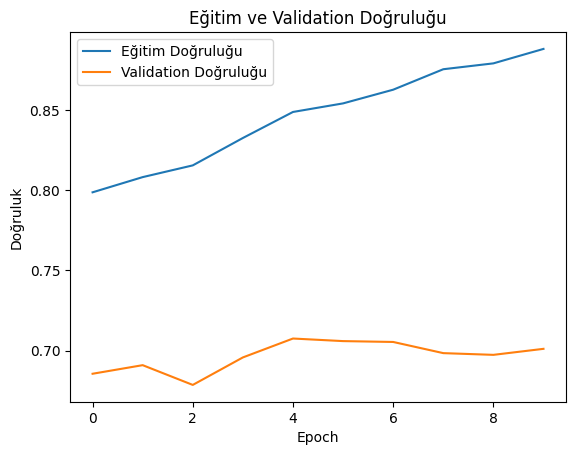

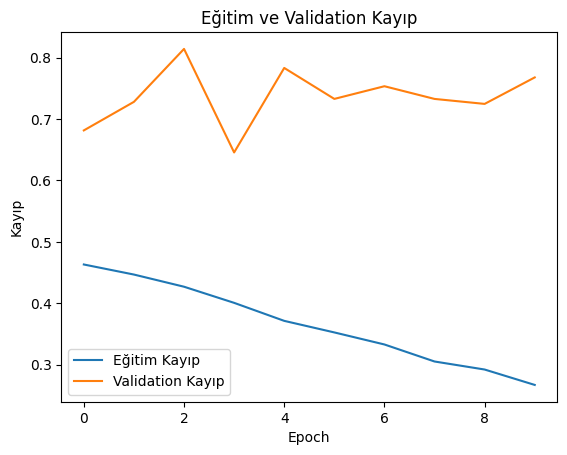

In [58]:
# Modeli değerlendirme (Validation verisi ile)
validation_loss, validation_acc = model.evaluate(validation_images, validation_labels_encoded)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_acc}")

# Eğitim doğruluğu ve kayıp
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Validation Doğruluğu')
plt.title('Eğitim ve Validation Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim kaybı ve validation kaybı
plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Validation Kayıp')
plt.title('Eğitim ve Validation Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()